In [19]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Sample rate: 416.811119576602 Hz
Orientation: 40.273560603003766 deg
Index(['Motor Torque [Nm]', 'Deflection [deg]', 'Desired Torque [Nm]',
       'Q_current/5', 'test_nr'],
      dtype='object')


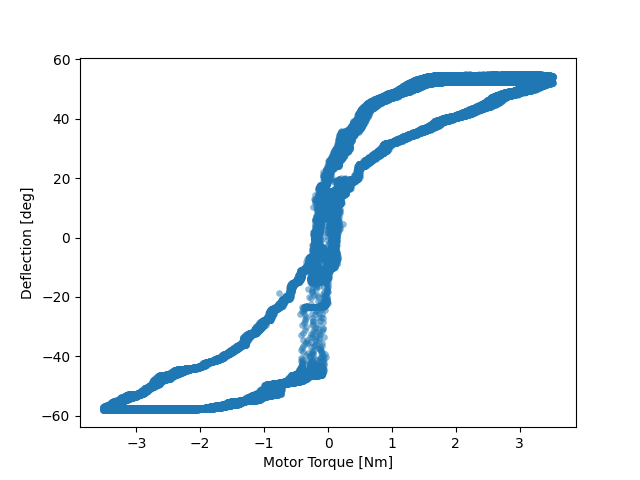

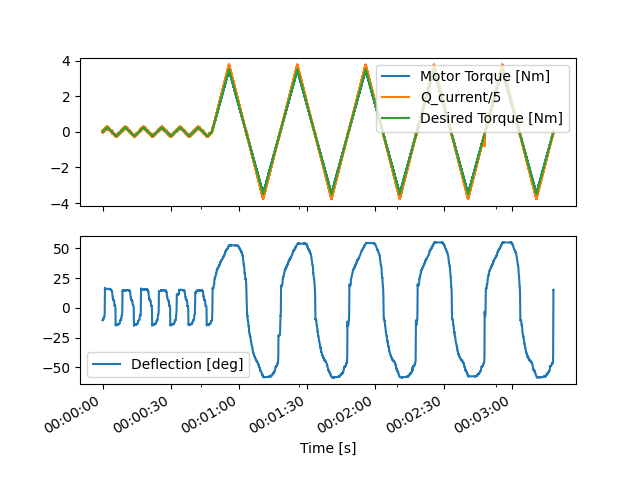

In [20]:
# filename = 'test_data/2024-06-18_17-38-36_torqueramp_baseline.csv'              # decent results
# filename = 'test_data/2024-06-19__12-25-18__torqueramp__Baseline.csv'         # minimal movement

# filename = 'test_data/2024-06-19__12-54-08__torqueramp__Baseline PCCF.csv'    # good results
filename = 'test_data/2024-06-19__14-26-39__torqueramp__Baseline PCCF.csv'  # best results
filename = 'test_data/2024-06-19__14-50-18__torqueramp__Baseline PCCF.csv'   # higer torque, rotor sticking near end

df_raw = pd.read_csv(filename)
# print(df_raw.head())

df = pd.DataFrame()
df['Time [s]'] = df_raw['TIME']
df['Motor Torque [Nm]'] = df_raw['TORQUE']  #.rolling(window=20, center=True).mean()
df['Deflection [deg]'] = df_raw['POSITION'] * 360
df['Desired Torque [Nm]'] = df_raw['CONTROL_TORQUE']
df['Q_current/5'] = df_raw['Q_CURRENT']/5
df['test_nr'] = df_raw['test_nr']

sample_rate = 1/(df['Time [s]'].diff().mean())
# to datetime
df['Time [s]'] = pd.to_datetime(df['Time [s]'], unit='s')
df.set_index('Time [s]', inplace=True)

orientation = df['Deflection [deg]'].mean()
df['Deflection [deg]'] -= orientation

print(f'Sample rate: {sample_rate} Hz')
print(f'Orientation: {orientation} deg')
print(df.columns)
# print(df.head())

fig, axs = plt.subplots(2, 1, sharex=True)
df.plot(y=['Motor Torque [Nm]', 'Q_current/5', 'Desired Torque [Nm]'], ax=axs[0])
df.plot(y='Deflection [deg]', ax=axs[1])

hyst_ax = df.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', linewidth=0.2, alpha=0.5)
# df.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=hyst_ax)
plt.show()

test 0 resampled from 3398 to 16018 samples
test 1 resampled from 3341 to 16017 samples
test 2 resampled from 3258 to 16008 samples
test 3 resampled from 3360 to 16014 samples
test 4 resampled from 3346 to 16018 samples
test 5 resampled from 3327 to 16005 samples
setting everything to 16005 samples
test 0 resampled from 12410 to 60025 samples
test 1 resampled from 12485 to 60026 samples
test 2 resampled from 12567 to 60031 samples
test 3 resampled from 12601 to 60030 samples
test 4 resampled from 12533 to 60029 samples
setting everything to 60025 samples


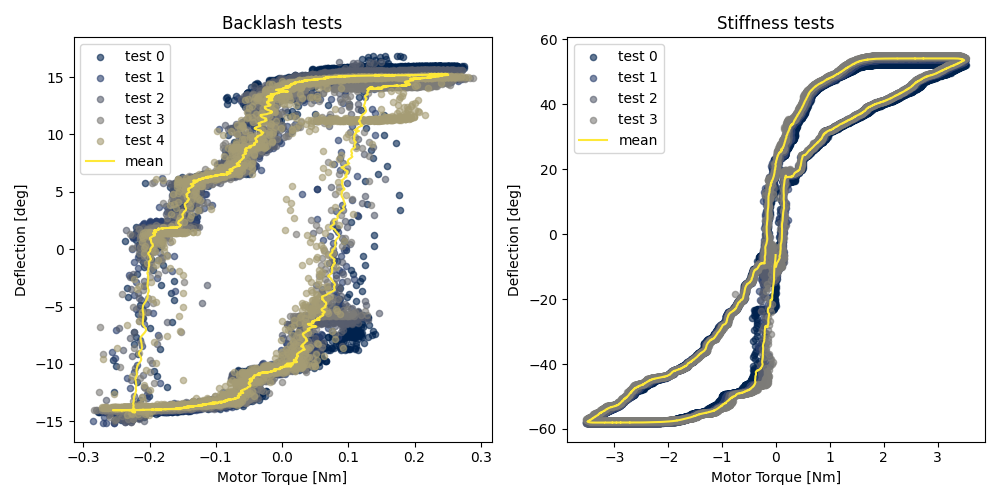

In [21]:
def average_data(df):
    data = []
    grouped = df.groupby('test_nr')

    for name, group in grouped:
        group = group.drop('test_nr', axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.5ms').mean()
        group = group.interpolate(method='time')
        print(f'test {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop('test_nr')
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=30).mean()
    mean_df = mean_df.bfill()
    mean_df = mean_df.ffill()

    return mean_df


TEST_NR_OFFSET = 100
play_tests = df[df['test_nr'] < TEST_NR_OFFSET].copy()
stiffness_tests = df[df['test_nr'] >= TEST_NR_OFFSET].copy()
stiffness_tests['test_nr'] = stiffness_tests['test_nr'] - TEST_NR_OFFSET

play_test_mean = average_data(play_tests)
stiffness_test_mean = average_data(stiffness_tests)


# plot torque ramp curves for each test, then overlay mean
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
colors = plt.cm.cividis(np.linspace(0, 1, play_tests['test_nr'].max() + 2))

for i in range(0, play_tests['test_nr'].max()):
    test = play_tests[play_tests['test_nr'] == i]
    color = np.array([colors[i]])
    test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', ax=axs[0], alpha=0.6, label=f'test {i}', color=color)
color = np.array([colors[-1]])
play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='mean', color=color) 
axs[0].set_title('Backlash tests')

for i in range(0, stiffness_tests['test_nr'].max()):
    test = stiffness_tests[stiffness_tests['test_nr'] == i]
    color = np.array([colors[i]]) 
    test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', ax=axs[1], alpha=0.6, label=f'test {i}', color=color)
color = np.array([colors[-1]]) 
stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='mean', color=color)
axs[1].set_title('Stiffness tests')

# save plot
fig.tight_layout()
fig.savefig(f'{filename}.png')
plt.show()

In [30]:
def get_rising_slopes(df):
    # split data in to positive and negative slopes. remove the hysteresis part
    max_torque_idx = df['Desired Torque [Nm]'].idxmax()
    pos_slope = df.loc[:max_torque_idx]

    # find zero crossing of desired torque
    min_torque_idx = df['Desired Torque [Nm]'].idxmin()
    zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
    neg_slope = df.loc[zero_torque_idx:min_torque_idx]

    return pos_slope, neg_slope


# estimate play
play_pos_slope, play_neg_slope = get_rising_slopes(play_test_mean)
pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
print(f'Play: {pos_play-neg_play} deg ({pos_play} pos, {neg_play} neg)')


# estimate stiffness
stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(stiffness_test_mean)
stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > pos_play]
stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] > neg_play]

# do polyfit
pos_offset, pos_stifness = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
neg_offset, neg_stifness = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

print(f'Positive stiffness: {pos_stifness} deg/Nm, offset: {pos_offset} deg')
print(f'Negative stiffness: {neg_stifness} deg/Nm, offset: {neg_offset} deg')


Play: -24.14715074811663 deg (-10.307466722214146 pos, 13.839684025902482 neg)
Positive stiffness: 15.392492051857323 deg/Nm, offset: 12.085349876981693 deg
Negative stiffness: 20.779515207995793 deg/Nm, offset: 58.72058119204289 deg


Backlash tests


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

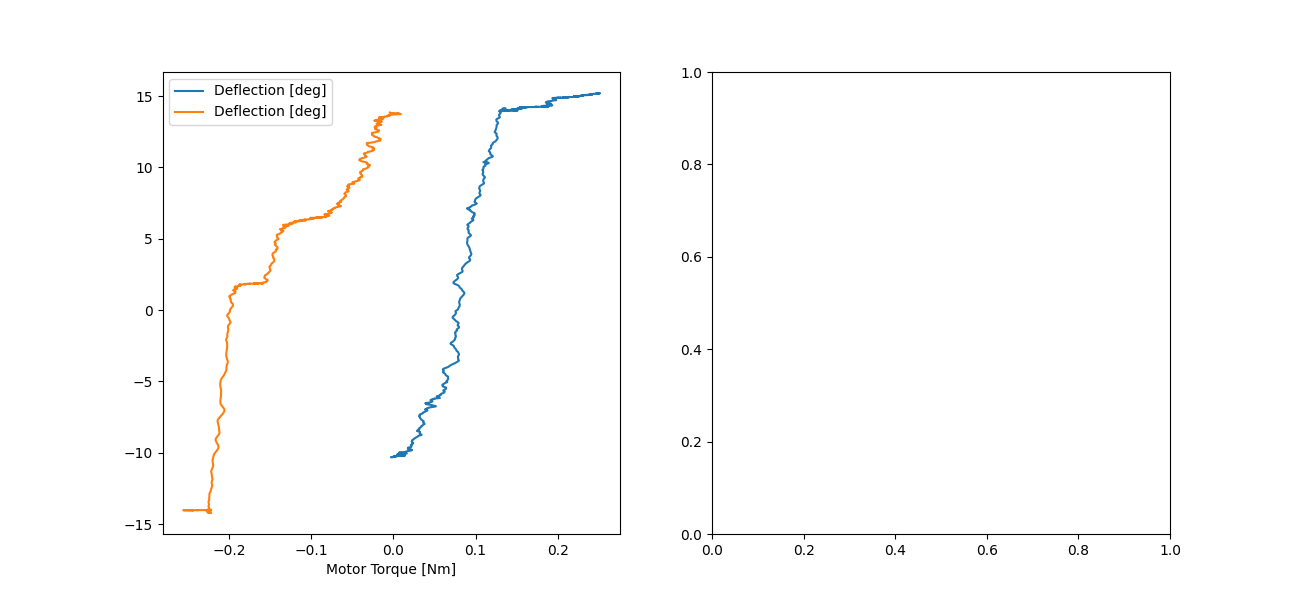

In [26]:
import pwlf

def estimate_play_stiffness(df, ax):
    # split data in to positive and negative slopes. remove the hysteresis part
    max_torque_idx = df['Desired Torque [Nm]'].idxmax()
    pos_slope = df.loc[:max_torque_idx]

    # find zero crossing of desired torque
    min_torque_idx = df['Desired Torque [Nm]'].idxmin()
    zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
    neg_slope = df.loc[zero_torque_idx:min_torque_idx]

    # plot selected segments
    pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', ax=ax)
    neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', ax=ax)

    # fit 2 piece linear model
    pos_pwlf = pwlf.PiecewiseLinFit(pos_slope['Motor Torque [Nm]'], pos_slope['Deflection [deg]'])
    neg_pwlf = pwlf.PiecewiseLinFit(neg_slope['Motor Torque [Nm]'], neg_slope['Deflection [deg]'])

    pos_res = pos_pwlf.fit_with_breaks([0.1])
    neg_res = neg_pwlf.fit_with([0.2])

    pos_xHat = np.linspace(min(pos_slope['Motor Torque [Nm]']), max(pos_slope['Motor Torque [Nm]']), num=10000)
    neg_xHat = np.linspace(min(neg_slope['Motor Torque [Nm]']), max(neg_slope['Motor Torque [Nm]']), num=10000)

    pos_yHat = pos_pwlf.predict(pos_xHat)
    neg_yHat = neg_pwlf.predict(neg_xHat)

    ax.plot(pos_xHat, pos_yHat, '-')
    ax.plot(neg_xHat, neg_yHat, '-')

    pos_play = pos_res[1] - pos_res[0]
    neg_play = neg_res[1] - neg_res[0]

    pos_stiffness = (pos_slope['Deflection [deg]'].max() - pos_slope['Deflection [deg]'].min()) / pos_play
    neg_stiffness = (neg_slope['Deflection [deg]'].max() - neg_slope['Deflection [deg]'].min()) / neg_play


    print(f'Positive slope: play {pos_play:.3f} deg, stiffness {pos_stiffness:.3f} Nm/deg')
    print(f'Negative slope: play {neg_play:.3f} deg, stiffness {neg_stiffness:.3f} Nm/deg')
    print(f'total play: {pos_play + neg_play:.3f} deg. average stiffness: {(pos_stiffness + neg_stiffness)/2:.3f} Nm/deg')


fig, axs = plt.subplots(1, 2, figsize=(13, 6))

print('Backlash tests')
estimate_play_stiffness(play_test_mean, axs[0])

print('Stiffness tests')
estimate_play_stiffness(stiffness_test_mean, axs[1])

axs[0].set_title('Backlash tests')
axs[1].set_title('Stiffness tests')
fig.tight_layout()
plt.show()
